# Week4_5조_강은서

## 1. VGG19- CIFAR10
- 코드: https://github.com/deeplearningzerotoall/PyTorch/blob/master/lab-10_5_2_Aadvance-CNN(VGG_cifar10).ipynb
- 위의 코드에서 cfg 리스트를 VGG19에 맞게 수정후 epoch=2로 트레이닝, 16개의 convolution layer+ 3개의 fully connected layer
- 정확도 보고할 필요 X

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
#loss tracker 함수 정의
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             )

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),# 데이터 폼 텐서로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#정규화하기

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, 
                                          #batch_size 512
                                          # testloader에서만 shuffle=True로 바꿔줄것!
                                          shuffle=True, num_workers=0) # num_workers: 멀티 프로세스 값, 디폴트는 0(메인프로세스만)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') #label 값들

Extracting ./cifar10\cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

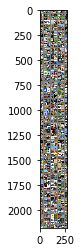

 ship truck  bird   dog


In [17]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
#vis.images(images/2 + 0.5)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
import torchvision.models.vgg as vgg

In [19]:
cfg = [32,32,'M',64,64,'M',128,128,128,128,'M',256,256,256,256,'M',512,512,512,512,'M'] #16 + 3 =vgg19 ; cfg 리스트를 VGG19에 맞게 수정

In [20]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096), #512 * 4 * 4 --> 512 * 1 * 1
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [21]:
vgg19= VGG(vgg.make_layers(cfg),10,True).to(device) #10은 클래스 개수

In [22]:
a=torch.Tensor(1,3,32,32).to(device) #텐서 크기가 배치 크기 × 채널 × 높이 × 너비 인 텐서 선언 
out = vgg19(a)
print(out)

tensor([[ 2.2050e-03,  1.5503e-03,  1.6003e-03,  1.4452e-04,  1.0723e-03,
          2.2150e-05, -1.1437e-03,  2.1674e-03, -5.7780e-04,  1.1803e-04]],
       grad_fn=<AddmmBackward>)


In [23]:
criterion = nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.SGD(vgg19.parameters(), lr = 0.005,momentum=0.9)

#lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
# 5 epoch마다 learning rate에 0.9배 해줌
# 그런데 우리 과제는 epoch=2로 트레이닝 할것이라 안해도 될듯...?

#### Training

In [24]:
print(len(trainloader))
epochs = 2 #epoch 2로 설정

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    #lr_sche.step(); epoch=2니까 걍 안하기로!
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:# print every 30 mini-batches
            print('[%d, %5d] loss: %.5f' % (epoch + 1, i + 1, running_loss/30))
            running_loss = 0.0
        

print('Finished Training')

98
[1,    30] loss: 2.30260
[1,    60] loss: 2.30261
[1,    90] loss: 2.30260
[2,    30] loss: 2.30254
[2,    60] loss: 2.30254
[2,    90] loss: 2.30255
Finished Training


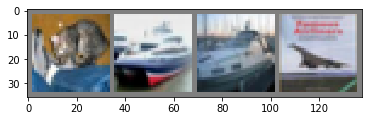

GroundTruth:    cat  ship  ship plane


In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [26]:
outputs = vgg19(images.to(device))

In [27]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  truck  bird truck truck


## 2. ResNet 34 - CIFAR10
https://github.com/deeplearningzerotoall/PyTorch/blob/master/lab-10_6_2_Advance-CNN(ResNet_cifar10).ipynb
- 위 링크의 코드 그대로 사용
- ResNet34 : block은 BasicBlock 사용하고, layer는 ResNet50처럼 [3, 4, 6, 3] 사용
- epoch 2번까지

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [38]:
import warnings
warnings.filterwarnings(action='ignore')

In [39]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

False

In [40]:
#define value_tracker
def value_tracker(value_plot, value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=value,
             win = value_plot,
             update='append'
             )

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [42]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)

print(trainset.data.shape)

train_data_mean = trainset.data.mean( axis=(0,1,2) )
train_data_std = trainset.data.std( axis=(0,1,2) )

print(train_data_mean)
print(train_data_std)

train_data_mean = train_data_mean / 255 #train 데이터셋의 mean과 std구한 후, 255로 나눠줌
train_data_std = train_data_std / 255

print(train_data_mean)
print(train_data_std)

Files already downloaded and verified
(50000, 32, 32, 3)
[125.30691805 122.95039414 113.86538318]
[62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [43]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### make ResNet50 using resnet

In [44]:
import torchvision.models.resnet as resnet

In [45]:
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [46]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        #x.shape =[1, 16, 32,32]
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        #x.shape =[1, 128, 32,32]
        x = self.layer2(x)
        #x.shape =[1, 256, 32,32]
        x = self.layer3(x)
        #x.shape =[1, 512, 16,16]
        x = self.layer4(x)
        #x.shape =[1, 1024, 8,8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [47]:
resnet34 = ResNet(resnet.BasicBlock, [3, 4, 6, 3], 10, True).to(device) 
# block은 BasicBlock 사용하고, layer는 ResNet50처럼 [3, 4, 6, 3] 사용
# 2*(3+4+6+3) +(conv1) +1(fc) = 32+2 = 34

In [48]:
a=torch.Tensor(1,3,32,32).to(device)
out = resnet34(a)
print(out)

tensor([[-0.0196, -0.0132, -0.0700,  0.0751,  0.0726, -0.0021,  0.0627, -0.0392,
          0.0873, -0.0145]], grad_fn=<AddmmBackward>)


In [52]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet34.parameters(), lr = 0.1, momentum = 0.9, weight_decay=5e-4)
#lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
print(len(trainloader))
epochs = 2 #문제에서 요구한대로 epoch=2로 설정


for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0


print('Finished Training')

196
Exception in user code:
------------------------------------------------------------
[1,    30] loss: 1.128


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[1,    60] loss: 1.064


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[1,    90] loss: 1.057


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[1,   120] loss: 1.055


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[1,   150] loss: 1.030


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[1,   180] loss: 0.959


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[2,    30] loss: 0.960


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[2,    60] loss: 0.926


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[2,    90] loss: 0.912


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[2,   120] loss: 0.902


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[2,   150] loss: 0.872


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

Exception in user code:
------------------------------------------------------------
[2,   180] loss: 0.894


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 84, in create_connection
    raise err
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1252, in request
    self._send_request

오류를 어떻게 고쳐야할지 모르겠어서 그냥 제출합니다.ㅠㅠ 해결방법을 찾으면 다시 올리겠습니다.